# Trabalho Final

Importando as bibliotecas que serão usadas

In [1]:
# Util
import operator
import math
import random
import numpy as np
from numpy import linspace, sin, pi, int16
import matplotlib.pyplot as plt
%matplotlib inline

# Genetic Programming
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

import librosa
import librosa.display
from IPython.display import Audio

import warnings; warnings.simplefilter('ignore')

Carregando o som desejado

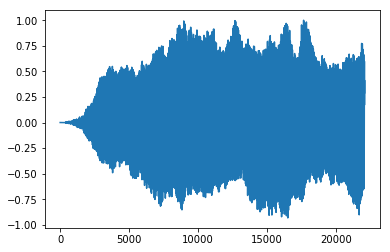

In [2]:
f0 = 440.0
target, sr = librosa.load('SOUNDS/au_sample.wav')
#target, sr = librosa.load('SOUNDS/flute.wav')
#target, sr = librosa.load('SOUNDS/harp.wav')
#target, sr = librosa.load('SOUNDS/string.wav')
target = librosa.util.normalize(target[:sr]) # normalizando etruncando para 1 segundo
duration = 1.0
plt.plot(target)
Audio(target,rate=sr)

In [3]:
# FUNCOES OPERADORES
def note(freq, amp=1.0):
    t = linspace(0,1.0,1.0*22050)
    data = sin(2.0*pi*freq*t)*amp
    return data

def fm(c_amp,c_freq, note_mod):
    t = linspace(0,1.0,1.0*22050)
    data = c_amp * sin(2.0*pi *(c_freq*t + note_mod))
    return data


In [4]:
def evaluate(individual):
    func = toolbox.compile(expr=individual)
    candidate = librosa.util.normalize(func(f0))
    
    candidate_mag = librosa.util.normalize(np.abs(librosa.stft(candidate)), axis=1)
    candidate_pha = librosa.util.normalize(np.angle(librosa.stft(candidate)), axis=1)
    
    target_mag = librosa.util.normalize(np.abs(librosa.stft(target)), axis=1)
    target_pha = librosa.util.normalize(np.angle(librosa.stft(target)), axis=1)
    
    mag_error = np.mean((candidate_mag - target_mag)**2)
    pha_error = np.mean((candidate_pha - target_pha)**2)
    
    return mag_error*0.7 + pha_error*0.3,

In [5]:
def evaluate_max(individual):
    func = toolbox.compile(expr=individual)
    candidate = librosa.util.normalize(func(f0))
    
    candidate_mag = np.abs(librosa.stft(candidate))
    candidate_pha = np.angle(librosa.stft(candidate))
    
    target_mag = np.abs(librosa.stft(target))
    target_pha = np.angle(librosa.stft(target))
    
    mag_error = np.max((candidate_mag - target_mag)**2)
    pha_error = np.max((candidate_pha - target_pha)**2)
    
    return (mag_error*0.7 + pha_error*0.3),

In [6]:
# PROGRAMAÇÂO GENETICA
pset = gp.PrimitiveSetTyped("MAIN", [float], np.ndarray, "F")

# OPERATORS
pset.addPrimitive(note, [float, float], np.ndarray)
pset.addPrimitive(operator.add,[np.ndarray,np.ndarray],np.ndarray)
pset.addPrimitive(operator.mul,[np.ndarray,np.ndarray],np.ndarray)
pset.addPrimitive(fm, [float,float,np.ndarray], np.ndarray)
pset.addPrimitive(operator.add,[float,float],float)
# pset.addPrimitive(gen_cos, [float,float], list)

# TERMINALS
# if not scoop.IS_ORIGIN:
#    pset.addEphemeralConstant("rand100", lambda: random.random() * 100, float)
pset.addEphemeralConstant("rand100", lambda: random.random() * 100, float)
pset.addEphemeralConstant("rand101", lambda: random.randint(-1,1), float)
pset.addTerminal(note(0), np.ndarray, 'zero')
pset.addTerminal(note(f0), np.ndarray, 'fundamental')
pset.addTerminal(note(2*f0), np.ndarray, 'harm1')
pset.addTerminal(note(3*f0), np.ndarray, 'harm2')
pset.addTerminal(note(4*f0), np.ndarray, 'harm3')
pset.addTerminal(f0, float)
pset.addTerminal(2*f0, float)
pset.addTerminal(3*f0, float)
pset.addTerminal(4*f0, float)

# CONFIG
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
# toolbox.register("map", futures.map)
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

toolbox.register("evaluate", evaluate_max)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=10))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=10))

In [7]:
def main():
    random.seed(10)
    pop = toolbox.population(n=20000)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    algorithms.eaSimple(pop, toolbox, 0.75, 0.2, 100, stats, halloffame=hof)

    return pop, stats, hof

In [8]:
pop, stats, hof = main()

gen	nevals	avg   	std   	min    	max   
0  	20000 	112585	111352	13289.6	731693
1  	16091 	71462 	62287.3	13289.6	732585
2  	16003 	57984.8	51805.5	12316.8	724917
3  	16015 	48135  	41392.8	12316.8	724917
4  	16017 	42128.9	36918.1	12316.8	724917
5  	16034 	39093.3	34515  	12316.8	724917
6  	15931 	36600.5	32713.6	12218.1	724917
7  	16085 	35550.6	33478.2	12201.3	731704
8  	15937 	34703.2	32873  	12201.3	724917
9  	16040 	34502.4	35139.6	12201.3	724917
10 	16061 	34696.6	37956.9	12201.3	724917
11 	16039 	33957.7	34470  	12201.3	724917
12 	16024 	33327.7	34919.9	12199.3	724917
13 	16015 	33061.2	34001.4	12199.3	724917
14 	16151 	32258.9	33134  	11751.5	724917
15 	16018 	31089.7	31583.6	11751.5	724917
16 	15890 	29522.9	29855  	11751.5	724917
17 	16073 	29407.1	29426  	11740  	724917
18 	16005 	28129  	28660.3	11740  	724917
19 	16023 	28022.7	27584.1	11730.9	724917
20 	15961 	27504.9	28714.4	11730.9	724917
21 	15871 	26732.7	28029.7	11730.9	724917
22 	15942 	25966.4	28092.1	11730.9	7249

In [9]:
str(hof[0])

'add(fm(add(add(880.0, 1760.0), add(F0, 440.0)), 440.0, harm2), add(add(fm(add(1760.0, 1320.0), 440.0, fundamental), fm(add(1320.0, 880.0), add(99.5774476891771, 1320.0), fm(-1, 0, harm3))), add(harm2, harm2)))'

In [10]:
func = toolbox.compile(hof[0])
candidate = librosa.util.normalize(func(f0))
Audio(candidate,rate=sr)

In [11]:
librosa.output.write_wav('SOUNDS/gen_au_sa2.wav',candidate,sr)

In [12]:
def print_signals(target,candidate):
    plt.figure(1,figsize=(15, 9))
    plt.subplot(221)
    plt.plot(target)
    
    plt.subplot(222)
    plt.plot(candidate)
    
    plt.subplot(223)
    D_target = librosa.amplitude_to_db(librosa.stft(target), ref=np.max)
    librosa.display.specshow(D_target, y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('TARGET')
    
    plt.subplot(224)
    D_candidate = librosa.amplitude_to_db(librosa.stft(candidate), ref=np.max)
    librosa.display.specshow(D_candidate, y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('CANDIDATE')

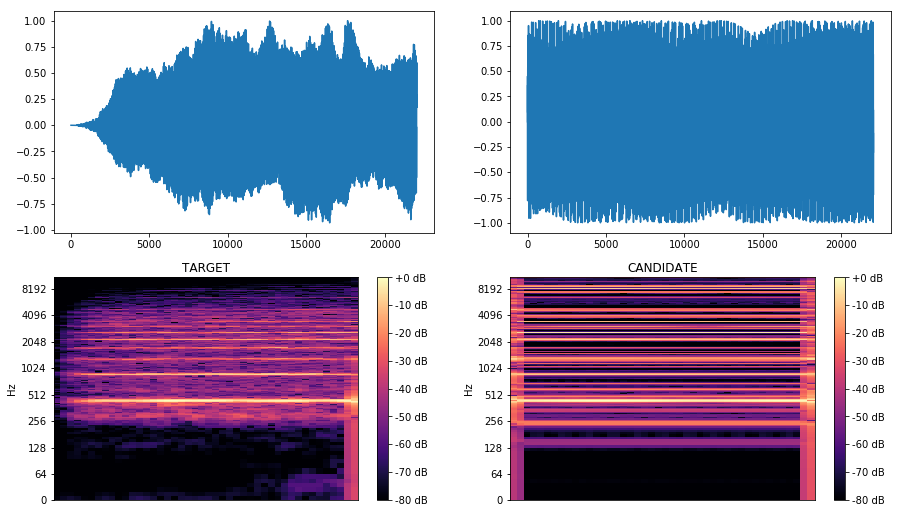

In [13]:
print_signals(target,candidate)